In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import imageio as io
import os
from google.colab.patches import cv2_imshow
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import cv2 as cv
import torch.nn as nn
from PIL import Image
import os
import albumentations as A
from albumentations.pytorch import ToTensor
from glob import glob
from tqdm  import tqdm
from torch.utils.data import Dataset
from genericpath import exists
import albumentations as A
from torch.utils.data import DataLoader
import matplotlib.image as mpimg
import imghdr
import mimetypes
import torchvision.transforms as tt
import torch.optim as optim
import numpy as np

In [26]:
np.random.seed(42)

In [27]:
train_image_dir           =  "/content/drive/MyDrive/retinal_blood_vessels/training/images"
train_mask_dir            =  "/content/drive/MyDrive/retinal_blood_vessels/training/1st_manual"
test_image_dir            =  "/content/drive/MyDrive/retinal_blood_vessels/test/images"
test_mask_dir             =  "/content/drive/MyDrive/retinal_blood_vessels/test/mask"
path1                     =  "/content/Data/Train/Images"
path2                     =  "/content/Data/Train/Masks"
path3                     =  "/content/Data/Test/Images"
path4                     =  "/content/Data/Test/Masks"
past_add = [path1,path2,path3,path4]
copy_add  = [train_image_dir,train_mask_dir,test_image_dir,test_mask_dir]

def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)
for path in past_add:
  create_dir(path)

In [28]:
for x in copy_add:
  images  =os.listdir(x)
  print(len(images))
  for image in sorted(images):
    print(image)
    break
  break

20
21_training.tif


In [29]:
def saving_data(save_add,collecting_add):
  images  = sorted(glob(os.path.join(collecting_add,'*')))
  #print(len(images))
  for image in images:
    image_extension = image.split('/')[-1].split('.')[1] 
    if image_extension=='tif':
      image_name  = image.split('/')[-1].replace('.tif','.jpeg')
      image = cv.imread(image)
      image=  cv.resize(image,(512,512),interpolation=cv.INTER_LANCZOS4)
      cv.imwrite(os.path.join(save_add,image_name),image)
    else:
      image_name  = image.split('/')[-1].replace('.gif','.jpeg')
      image = np.array(Image.open(image))   
      image=  cv.resize(image,(512,512),interpolation=cv.INTER_AREA)

      cv.imwrite(os.path.join(save_add,image_name),image)
    
    
for (in_add,out_add) in zip(past_add,copy_add):
  saving_data(in_add,out_add)

In [30]:
train_x   = sorted(glob(os.path.join(past_add[0],'*.jpeg')))
train_y   = sorted(glob(os.path.join(past_add[1],'*.jpeg')))
test_x   = sorted(glob(os.path.join(past_add[2],'*.jpeg')))
test_y   = sorted(glob(os.path.join(past_add[3],'*.jpeg')))

print(len(train_x),len(train_y),len(test_x),len(test_y))

20 20 20 20


In [31]:
class data_set(Dataset):
  def __init__(self, image_dir,mask_dir,transform=None):
    super().__init__()
    #self.image_dir  = image_dir
    #self.mask_dir = mask_dir
    self.images   = image_dir
    self.masks    = mask_dir
    self.transform  = transform
    self.n_samples= len(image_dir)
  def __len__(self):
    return self.n_samples
  def __getitem__(self,index):
    image_path  = os.path.join(self.images[index])
    mask_path   = os.path.join(self.masks[index])
    image = cv.imread(image_path)#.transpose(2,0,1)
    image = np.resize(image,(512,512,3))
    mask  = np.array(Image.open(mask_path).convert("L"))
    mask  = np.resize(mask,(512,512))
    
    if self.transform is not None:
      augmentation  = self.transform(image=image,mask=mask)
      image = augmentation['image']
      mask  = augmentation['mask']     
    return image,mask

(512, 512, 3)


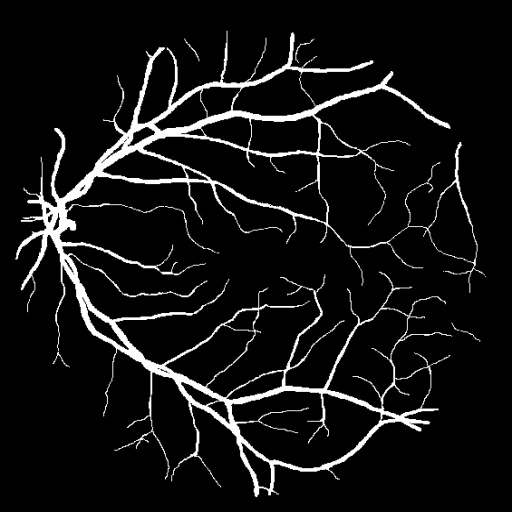

In [32]:
image = cv.imread('/content/Data/Train/Masks/21_manual1.jpeg')
print(image.shape)
cv2_imshow(image)

In [33]:
from torch.autograd import grad
train_transforms  =  A.Compose([
                                #A.Resize(height=512,width=512,interpolation=cv.INTER_LINEAR)
                                A.Rotate(limit=35,p=1.0,interpolation=cv.INTER_LINEAR),
                                A.HorizontalFlip(p=1.0),
                                A.VerticalFlip(p=0.5),
                                #A.Normalize(mean=[0.0,0.0,0.0],
                                #            std=[1.0,1.0,1.0],
                                #            max_pixel_value=255.0),
                               ToTensor()
                                ])
val_transforms   =  A.Compose([
                                #A.Resize(image_width,image_height),
                                #A.Normalize(mean=[0.0,0.0,0.0],
                                #            std=[1.0,1.0,1.0],
                                #            max_pixel_value=255.0),
                                ToTensor()
                                ])

In [34]:
class conv_block(nn.Module):
  def __init__(self,in_ch,out_ch):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_ch,out_ch,padding=1,stride=1,kernel_size=3),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(out_ch),
        nn.Conv2d(out_ch,out_ch,padding=1,stride=1,kernel_size=3),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(out_ch)
    )
  def forward(self,input):
    return(self.conv(input))

In [35]:
class Unet(nn.Module):
  def __init__(self,in_ch,out_ch,features=[64,128,256,512]):
    super().__init__()
    self.downs= nn.ModuleList()
    self.ups  = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    for feature in features:
      self.downs.append(conv_block(in_ch,feature))
      in_ch= feature
    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(feature*2,feature,stride=2,kernel_size=2))
      self.ups.append(conv_block(feature*2,feature))
    self.bottleneck=  conv_block(features[-1],features[-1]*2)
    self.final    =   conv_block(features[0],out_ch)
  def forward(self,x):
    skip_connections  = []
    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)
    skip_connections=skip_connections[::-1]
    x  = self.bottleneck(x)
    for index in range (0, len(self.ups), 2):
      x = self.ups[index](x)
      skip_connection = skip_connections[index//2]
      x = torch.cat((x,skip_connection),dim=1)
      x = self.ups[index+1](x)
    return self.final(x)

In [36]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
     return torch.device('cpu')
device  = get_default_device()
def to_device(data,device):
  if isinstance(data,(tuple,list)):
    return [to_device(x,device) for x in data]
  else:
    return data.to(device,non_blocking=True)
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    for x in self.dl:
      yield to_device(x,self.device)
  def __len__(self):
    return len(self.dl)
print(device)

cuda


In [37]:
data  = data_set(train_x,train_y,train_transforms)
val_data  = data_set(train_x,train_y,val_transforms)
device  = get_default_device()
train_dl  = DataLoader(data,batch_size=1,shuffle=True,num_workers=1,pin_memory=True)
test_dl   = DataLoader(val_data,batch_size=1,shuffle=False,num_workers=1,pin_memory=True)

print(device)
model=to_device(Unet(3,1),device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)
scaler  = torch.cuda.amp.GradScaler()
train_dl  = DeviceDataLoader(train_dl,device)
test_dl = DeviceDataLoader(test_dl,device)

cuda


In [38]:
def train_fn(loader,model,loss_fn,optimizer,scaler):
  loop=tqdm(loader)
  for batch_index,(x,y) in enumerate(loop):

    with torch.cuda.amp.autocast():
      prediction  = model(x)
      loss  = loss_fn(prediction,y)

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    loop.set_postfix(loss=loss.item())
    return loss

In [60]:
for epoch in range(200):
 loss =  train_fn(train_dl,model,loss_fn,optimizer,scaler)

  0%|          | 0/20 [00:01<?, ?it/s, loss=0.672]


In [61]:
def check_accuracy(loader,model,loss_fn):
  images  = []
  with torch.no_grad():
      for (x,y) in loader:
        preds = model(x)
        loss  = loss_fn(preds,y)
        images.append(preds)
  return images

In [ ]:
images  = check_accuracy(test_dl,model,loss_fn)

In [ ]:

for image in images:
  print(f"shape of image before sequezing is =========={image.shape}")
  image= np.squeeze(image,axis=1)
  print(f"shape of image after sequezing is =========={image.shape}")

  image = torch.permute(image,(1,2,0))
  image  = image.cpu().detach().numpy()
  #image = np.reshape(image,(512,512))
  print(image.shape)
  
  image[image>.5]=255
  print(image.min(),image.max(),image.mean())
  cv2_imshow(image)
  break

# unet-image-segment-final-shape

Use the "Run" button to execute the code.

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="unet-image-segment-final-shape")